In [ ]:
# 📌 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv('/content/HousePrice.csv')

In [ ]:
df.shape

(4600, 18)

In [ ]:
df = df[df['price'] > 0]
df.shape

(4551, 18)

In [ ]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')

In [ ]:
new_df = df.copy()
new_df['sale_year'] = pd.to_datetime(new_df['date']).dt.year
new_df['house_age'] = new_df['sale_year'] - new_df['yr_built']


# new_df['effective_age'] = new_df.apply(lambda x: x['sale_year'] - max(x['yr_built'], x['yr_renovated']), axis=1)
new_df['effective_age'] = np.where(
    new_df['yr_renovated'] > 0,
    new_df['sale_year'] - new_df['yr_renovated'],
    new_df['sale_year'] - new_df['yr_built']
)

new_df["condition_x_age"] = new_df["condition"] / (new_df["effective_age"] + 1)
new_df["view_x_floor"] = new_df["view"] * new_df["floors"]
new_df["luxury_score"] = (
    new_df["waterfront"]*5 +
    new_df["view"]*3 +
    new_df["condition"]*2
)


city_mean_price = new_df.groupby('city')['price'].mean()
new_df['city_encoded'] = new_df['city'].map(city_mean_price)
new_df['city_encoded'] = new_df['city_encoded'].round(2)


## Total rooms
new_df['total_rooms'] = new_df['bedrooms'] + new_df['bathrooms']

## Average room size *********************
new_df['avg_room_size'] = new_df['sqft_living'] / new_df['total_rooms']
new_df['avg_room_size'] = new_df['avg_room_size'].round(2)


## statezip encode_mean*******************
new_df['state_code'] = new_df['statezip'].str.extract(r'(\d+)')
new_df['state_code'] = new_df['state_code'].astype('int')

zip_price = new_df.groupby('state_code')['price'].mean().round(2)
new_df['statezip_price_mean'] = new_df['state_code'].map(zip_price)

## Floors*********************************
# new_df['floors_x_view'] = new_df['floors'] * new_df['view']
new_df["sqft_per_floor"] = new_df["sqft_living"] / new_df["floors"]




new_df['price_log'] = np.log(new_df['price'])
new_df['price_log'] = new_df['price_log'].round(2)

In [ ]:
new_df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country', 'sale_year', 'house_age', 'effective_age',
       'condition_x_age', 'view_x_floor', 'luxury_score', 'city_encoded',
       'total_rooms', 'avg_room_size', 'state_code', 'statezip_price_mean',
       'sqft_per_floor', 'price_log'],
      dtype='object')

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4551 entries, 0 to 4599
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 4551 non-null   object 
 1   price                4551 non-null   float64
 2   bedrooms             4551 non-null   float64
 3   bathrooms            4551 non-null   float64
 4   sqft_living          4551 non-null   int64  
 5   sqft_lot             4551 non-null   int64  
 6   floors               4551 non-null   float64
 7   waterfront           4551 non-null   int64  
 8   view                 4551 non-null   int64  
 9   condition            4551 non-null   int64  
 10  sqft_above           4551 non-null   int64  
 11  sqft_basement        4551 non-null   int64  
 12  yr_built             4551 non-null   int64  
 13  yr_renovated         4551 non-null   int64  
 14  street               4551 non-null   object 
 15  city                 4551 non-null   object

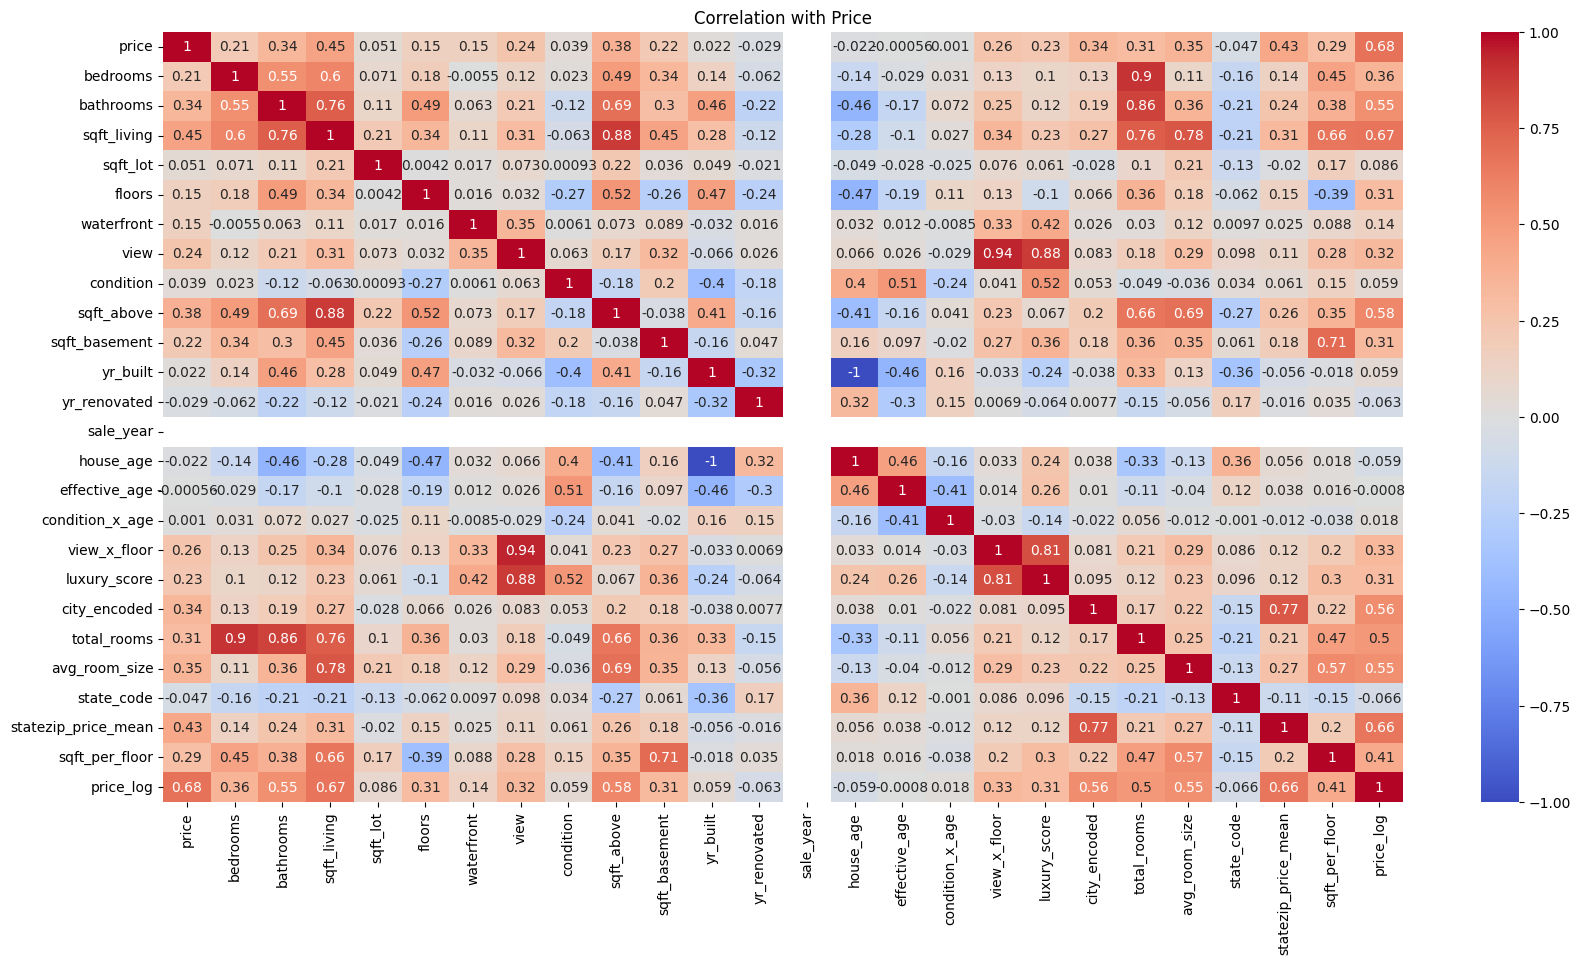

In [ ]:
numeric_data = new_df.select_dtypes(include=['int','float'])
plt.figure(figsize=(20,10))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation with Price")
plt.show()

In [ ]:
new_df = new_df.drop(['date','price','street','statezip','city','country','state_code'], axis=1)

new_df = new_df.drop(['sqft_lot','yr_built','sale_year','yr_renovated'], axis=1)


In [ ]:
import numpy as np

# কোন column এ infinity আছে দেখো
print(np.isinf(new_df).sum())

bedrooms               0
bathrooms              0
sqft_living            0
floors                 0
waterfront             0
view                   0
condition              0
sqft_above             0
sqft_basement          0
house_age              0
effective_age          0
condition_x_age        0
view_x_floor           0
luxury_score           0
city_encoded           0
total_rooms            0
avg_room_size          2
statezip_price_mean    0
sqft_per_floor         0
price_log              0
dtype: int64


In [ ]:
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df1.fillna(0, inplace=True)  # অথবা
new_df.dropna(inplace=True)

In [ ]:
# Features and target
X = new_df.drop(['price_log'], axis=1)
y = new_df['price_log']  # using log-transformed price

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
rf = RandomForestRegressor(n_estimators=200,
                           max_depth=15,min_samples_leaf=5,
                           min_samples_split=2,max_features='sqrt',
                           random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print('*'*50)


lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print('*'*50)


xgb = XGBRegressor(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.6,
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50,
    random_state=42
)
xgb.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost R2:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("Best n_estimators:", xgb.best_iteration)

Random Forest R2: 0.7849862242685715
Random Forest RMSE: 0.2560396066714626
**************************************************
Linear Regression R2: 0.7154984158778417
Linear Regression RMSE: 0.29452105873406476
**************************************************
XGBoost R2: 0.7819793591961476
XGBoost RMSE: 0.25782368682208545
Best n_estimators: 138


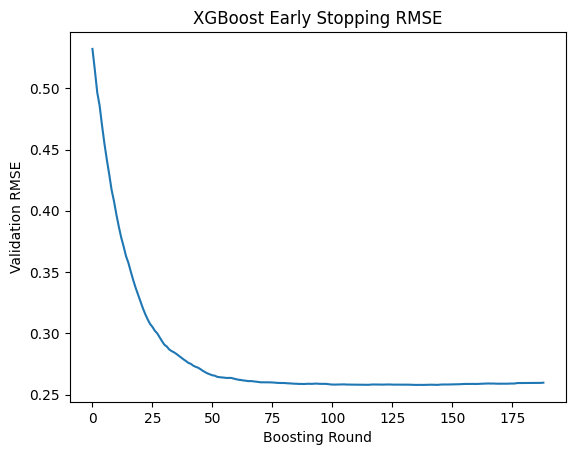

In [ ]:
results = xgb.evals_result()
import matplotlib.pyplot as plt

plt.plot(results['validation_0']['rmse'])
plt.xlabel("Boosting Round")
plt.ylabel("Validation RMSE")
plt.title("XGBoost Early Stopping RMSE")
plt.show()

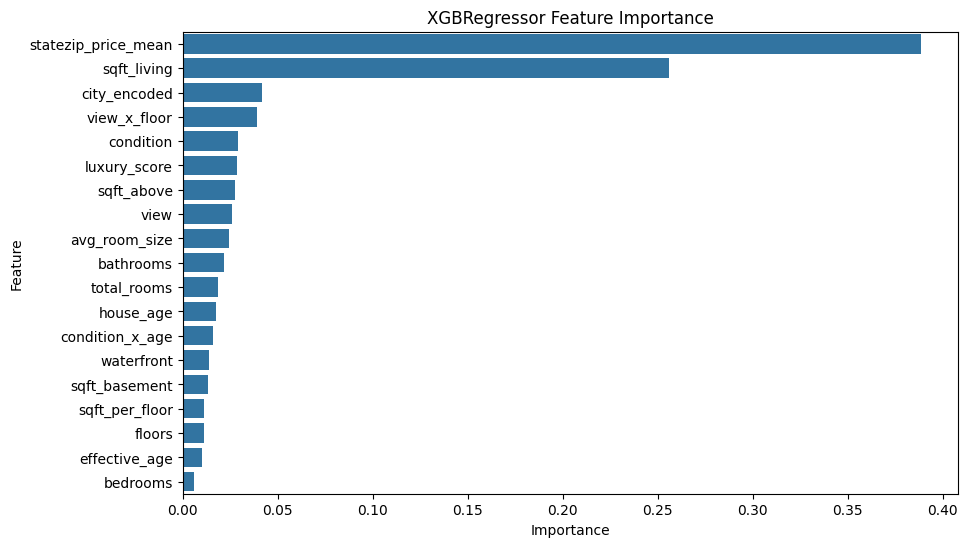

In [ ]:
importances = xgb.feature_importances_
feat_names = X.columns
feat_importance_df = pd.DataFrame({'Feature':feat_names, 'Importance':importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df)
plt.title("XGBRegressor Feature Importance")
plt.show()

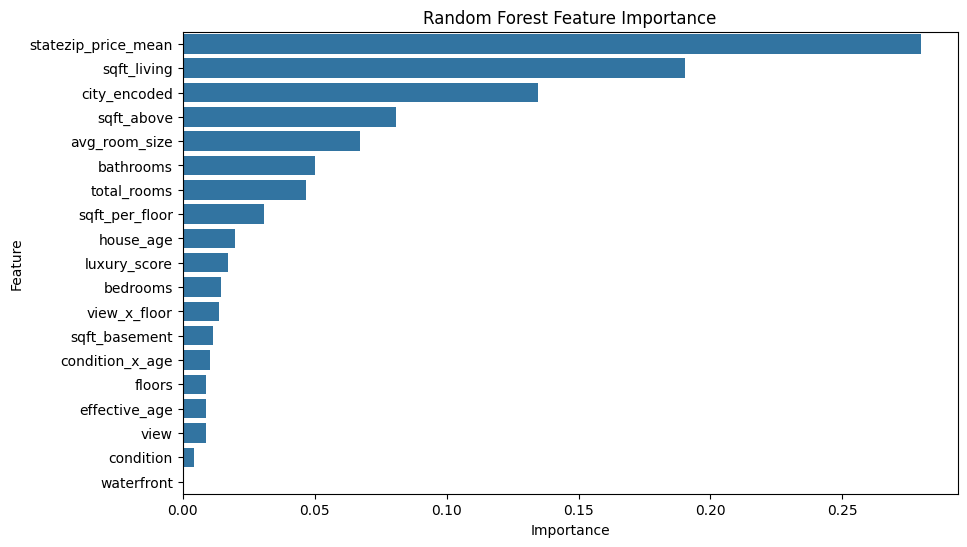

In [ ]:
importances = rf.feature_importances_
feat_names = X.columns
feat_importance_df = pd.DataFrame({'Feature':feat_names, 'Importance':importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df)
plt.title("Random Forest Feature Importance")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

rf_val = rf.predict(X_test)
xgb_val = xgb.predict(X_test)

ens_val = 0.4 * rf_val + 0.6 * xgb_val

rmse = np.sqrt(mean_squared_error(y_test, ens_val))
print("Ensemble RMSE:", rmse)
print("Ensemble R2", r2_score(y_test, ens_val))


Ensemble RMSE: 0.2542982737486751
Ensemble R2 0.7879009090919653


In [ ]:
new_df.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'condition', 'sqft_above', 'sqft_basement', 'house_age',
       'effective_age', 'condition_x_age', 'view_x_floor', 'luxury_score',
       'city_encoded', 'total_rooms', 'avg_room_size', 'statezip_price_mean',
       'sqft_per_floor', 'price_log'],
      dtype='object')

In [ ]:
reduce_df = new_df.copy()

In [ ]:
## RandomForest 79%
reduce_df = reduce_df.drop([
                  'floors',
                  'total_rooms',
                  'sqft_living',
                  'total_rooms'
                  ], axis=1)

In [ ]:
# Features and target
X = reduce_df.drop(['price_log'], axis=1)
y = reduce_df['price_log']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## RandomForestRegressor
rf = RandomForestRegressor(
                           n_estimators=250,
                           max_depth=None,
                           min_samples_leaf=2,
                           min_samples_split=5,max_features='sqrt',
                           random_state=42
                          )
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))


xgb = XGBRegressor(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.6,
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50,
    random_state=42
)
xgb.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False)

y_pred_xgb = xgb.predict(X_test)
print("XGBoost R2:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("Best n_estimators:", xgb.best_iteration)

Random Forest R2: 0.7901987921835711
Random Forest RMSE: 0.2529169876719523
XGBoost R2: 0.7834828373258185
XGBoost RMSE: 0.2569331682254366
Best n_estimators: 114


In [ ]:
y_train_pred = rf.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.xlabel("Actual (log price)")
plt.ylabel("Predicted (log price)")
plt.title("RF: Prediction vs Actual")
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         'r--')
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

rf_val = rf.predict(X_test)
xgb_val = xgb.predict(X_test)

# ens_val = 0.4 * rf_val + 0.6 * xgb_val
ensemble_pred_log = (rf_val + xgb_val) / 2


rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred_log))
print("Ensemble RMSE:", rmse)
print("Ensemble R2", r2_score(y_test, ensemble_pred_log))

In [ ]:
reduce_df.columns

Index(['bedrooms', 'bathrooms', 'waterfront', 'view', 'condition',
       'sqft_above', 'sqft_basement', 'house_age', 'effective_age',
       'condition_x_age', 'view_x_floor', 'luxury_score', 'city_encoded',
       'avg_room_size', 'statezip_price_mean', 'sqft_per_floor', 'price_log'],
      dtype='object')

In [ ]:
demo = reduce_df.drop([
                  'view_x_floor',
                  'luxury_score',
                  'condition_x_age',
],axis=1)
demo.shape

(4549, 14)

In [ ]:
demo.columns

Index(['bedrooms', 'bathrooms', 'waterfront', 'view', 'condition',
       'sqft_above', 'sqft_basement', 'house_age', 'effective_age',
       'city_encoded', 'avg_room_size', 'statezip_price_mean',
       'sqft_per_floor', 'price_log'],
      dtype='object')

In [ ]:
# Features and target
X = demo.drop(['price_log'], axis=1)
y = demo['price_log']  # using log-transformed price

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.6,
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50,
    random_state=42
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost R2:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("Best n_estimators:", xgb.best_iteration)
print("*"*50)


## RandomForestRegressor
rf = RandomForestRegressor(
                           n_estimators=250,
                           max_depth=None,
                           min_samples_leaf=2,
                           min_samples_split=5,max_features='sqrt',
                           random_state=42
                          )
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))



XGBoost R2: 0.7901972355749854
XGBoost RMSE: 0.25291792592208995
Best n_estimators: 153
**************************************************
Random Forest R2: 0.7887606133210274
Random Forest RMSE: 0.25378237505772905


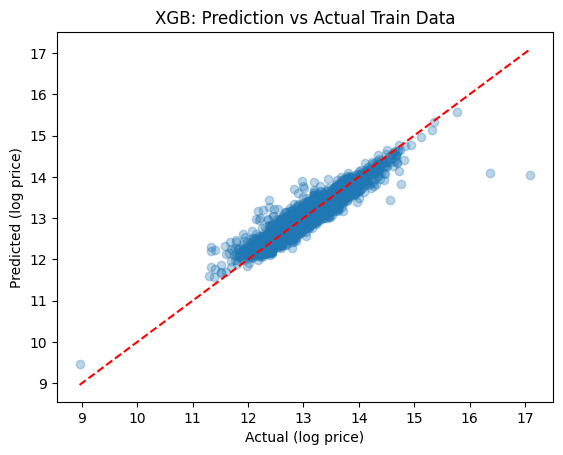

In [ ]:
y_train_pred = xgb.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.xlabel("Actual (log price)")
plt.ylabel("Predicted (log price)")
plt.title("XGB: Prediction vs Actual Train Data")
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         'r--')
plt.show()


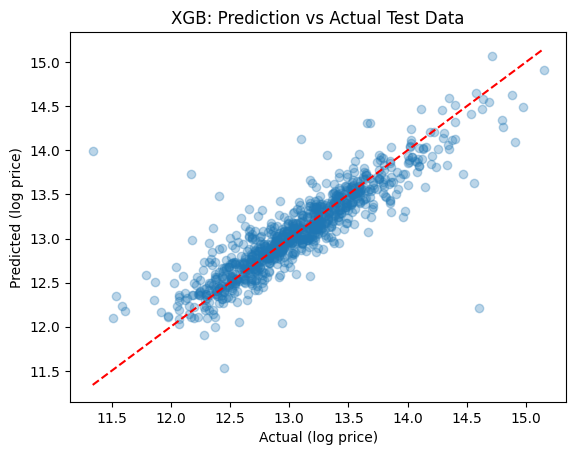

In [ ]:
y_test_pred = xgb.predict(X_test)

plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel("Actual (log price)")
plt.ylabel("Predicted (log price)")
plt.title("XGB: Prediction vs Actual Test Data")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.show()


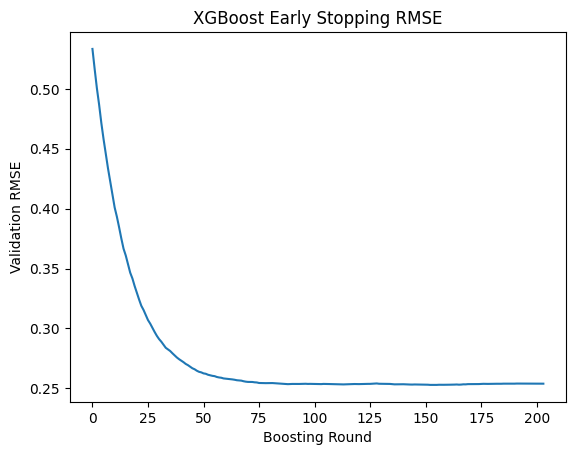

In [ ]:
results = xgb.evals_result()
import matplotlib.pyplot as plt

plt.plot(results['validation_0']['rmse'])
plt.xlabel("Boosting Round")
plt.ylabel("Validation RMSE")
plt.title("XGBoost Early Stopping RMSE")
plt.show()


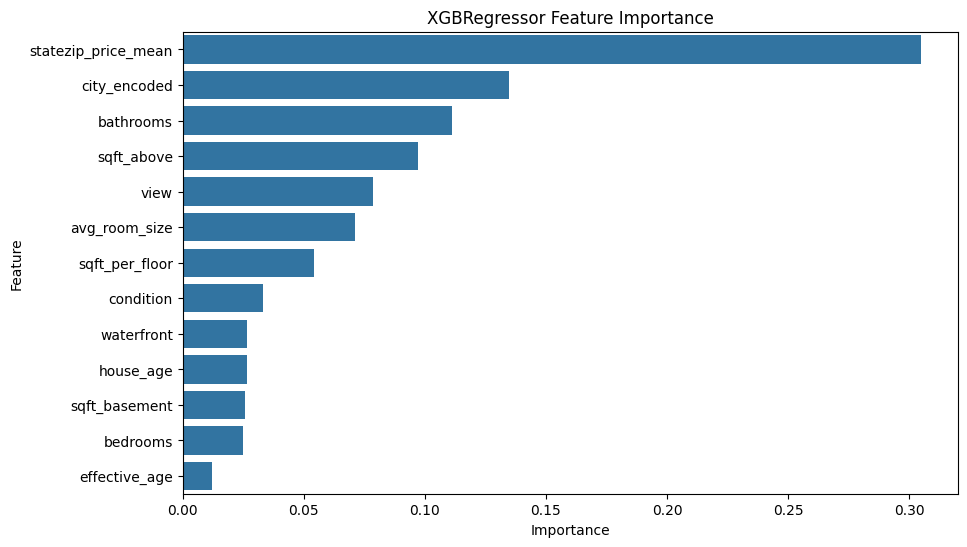

In [ ]:

importances = xgb.feature_importances_
feat_names = X.columns
feat_importance_df = pd.DataFrame({'Feature':feat_names, 'Importance':importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df)
plt.title("XGBRegressor Feature Importance")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

rf_val = rf.predict(X_test)
xgb_val = xgb.predict(X_test)

# ensemble_pred_log = 0.4 * rf_val + 0.6 * xgb_val
ensemble_pred_log = (rf_val + xgb_val) / 2


rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred_log))
print("Ensemble RMSE:", rmse)
print("Ensemble R2", r2_score(y_test, ensemble_pred_log))

Ensemble RMSE: 0.2509853394171838
Ensemble R2 0.7933912590087905


In [ ]:
from sklearn.model_selection import cross_val_score

# Create a new XGBRegressor instance without early stopping parameters for cross_val_score
xgb_cv = XGBRegressor(
    n_estimators=xgb.best_iteration, # Use the best number of estimators found
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.6,
    objective='reg:squarederror',
    random_state=42
)

cv_r2 = cross_val_score(xgb_cv, X_train, y_train, cv=5, scoring='r2')
print(cv_r2.mean())

0.7960173058977674


In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

# rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

# Grid of hyperparameters
# param_grid = {
#     'n_estimators': [200,250,300],      # number of trees
#     'max_depth': [None, 15, 20],      # max depth of tree
#     'min_samples_split': [2,5],      # min samples to split node
#     'min_samples_leaf': [2, 5],        # min samples per leaf
#     'max_features': ['auto', 'sqrt', 'log2']  # features to consider
# }

## xgb
param_grid = {
    'max_depth': [5, 6],
    'learning_rate': [0.05, 0.06],
    'n_estimators': [170,180,200],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.6, 0.7]
}


cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)


grid.fit(X_train, y_train)

# Best parameters
print("Best Params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

# Best estimator
best_rf = grid.best_estimator_

y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Random Forest with GridSearchCV")
print("R2 Score:", r2)
print("RMSE:", rmse)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 170, 'subsample': 0.7}
Best CV RMSE: 0.24213353959126707
Random Forest with GridSearchCV
R2 Score: 0.7873100758932071
RMSE: 0.25465222004090454


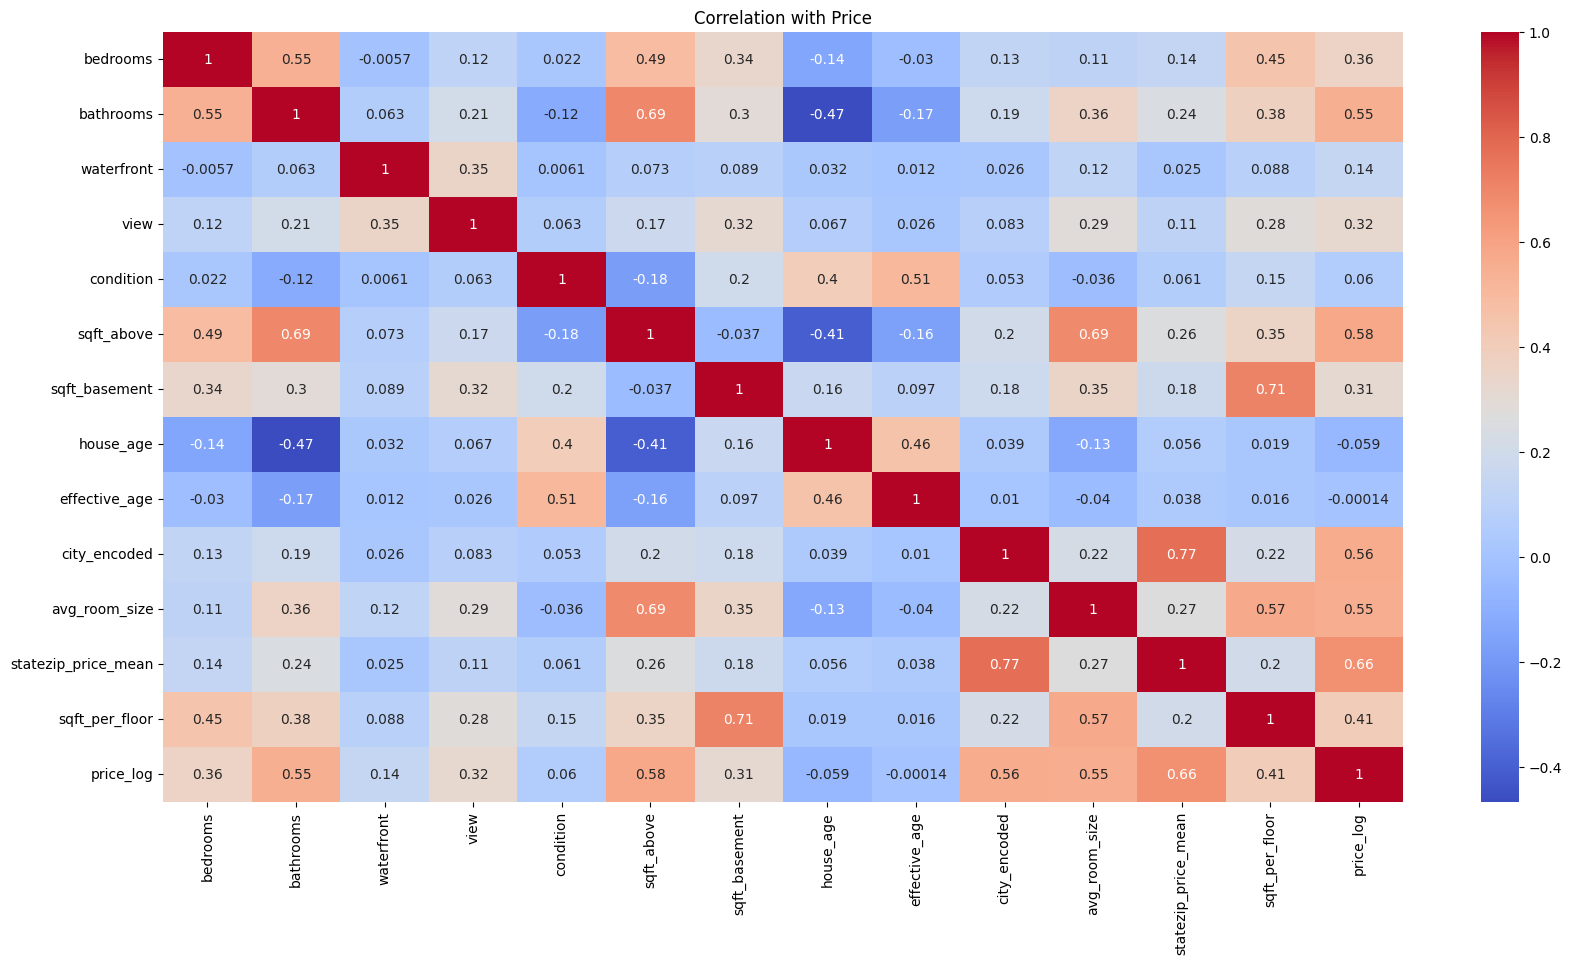

In [ ]:
numeric_data = demo.select_dtypes(include=['int','float'])
plt.figure(figsize=(20,10))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation with Price")
plt.show()

## Prediction

In [ ]:
def feature_engineering(df):
    df = df.copy()

    # date
    df['sale_year'] = pd.to_datetime(df['date']).dt.year

    # age
    df['house_age'] = df['sale_year'] - df['yr_built']

    df['effective_age'] = np.where(
        df['yr_renovated'] > 0,
        df['sale_year'] - df['yr_renovated'],
        df['sale_year'] - df['yr_built']
    )

    df['avg_room_size'] = df['sqft_living'] / (df['bedrooms'] + df['bathrooms'])
    df['avg_room_size'] = df['avg_room_size'].round(2)

    df['sqft_per_floor'] = df['sqft_living'] / df['floors']

    df['sqft_per_floor'] = df['sqft_per_floor'].round(2)


    df['state_code'] = df['statezip'].str.extract(r'(\d+)').astype(int)

    return df


In [ ]:
new_df = df.copy()
new_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [ ]:
xtrain_df = feature_engineering(new_df)

city_mean_price = xtrain_df.groupby('city')['price'].mean().round(2)
xtrain_df['city_encoded'] = xtrain_df['city'].map(city_mean_price)
# zip
xtrain_df['state_code'] = xtrain_df['statezip'].str.extract(r'(\d+)').astype(int)
zip_price = xtrain_df.groupby('state_code')['price'].mean().round(2)
xtrain_df['statezip_price_mean'] = xtrain_df['state_code'].map(zip_price)


GLOBAL_CITY_MEAN = city_mean_price.mean()
GLOBAL_ZIP_MEAN = zip_price.mean()


xtrain_df.head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,statezip,country,sale_year,house_age,effective_age,avg_room_size,sqft_per_floor,state_code,city_encoded,statezip_price_mean
0,2014-05-02 00:00:00,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,...,WA 98133,USA,2014,59,9,297.78,893.33,98133,420392.36,374433.23
1,2014-05-02 00:00:00,2384000.0,5.0,2.5,3650,9050,2.0,0,4,5,...,WA 98119,USA,2014,93,93,486.67,1825.00,98119,584294.90,914441.50
2,2014-05-02 00:00:00,342000.0,3.0,2.0,1930,11947,1.0,0,0,4,...,WA 98042,USA,2014,48,48,386.00,1930.00,98042,441880.99,326779.56


In [ ]:
xtrain_df['price_log'] = np.log(xtrain_df['price'])
xtrain_df['price_log'] = xtrain_df['price_log'].round(2)

In [ ]:
demo.columns

Index(['bedrooms', 'bathrooms', 'waterfront', 'view', 'condition',
       'sqft_above', 'sqft_basement', 'house_age', 'effective_age',
       'city_encoded', 'avg_room_size', 'statezip_price_mean',
       'sqft_per_floor', 'price_log'],
      dtype='object')

In [ ]:
# X_train['city_encoded'] = X_train['city'].map(city_mean)
# X_train['statezip_price_mean'] = X_train['state_code'].map(zip_mean)

drop_cols = ['sqft_lot','floors','sale_year','state_code',
    'price','date','city','statezip','country',
    'yr_built','yr_renovated','street','sqft_living'
]

train_data = xtrain_df.drop(columns=drop_cols)


In [ ]:
import numpy as np

# কোন column এ infinity আছে দেখো
print(np.isinf(train_data).sum())

bedrooms               0
bathrooms              0
waterfront             0
view                   0
condition              0
sqft_above             0
sqft_basement          0
house_age              0
effective_age          0
avg_room_size          2
sqft_per_floor         0
city_encoded           0
statezip_price_mean    0
price_log              0
dtype: int64


In [ ]:
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
# df1.fillna(0, inplace=True)  # অথবা
train_data.dropna(inplace=True)

In [ ]:
import numpy as np

# কোন column এ infinity আছে দেখো
print(np.isinf(train_data).sum())

bedrooms               0
bathrooms              0
waterfront             0
view                   0
condition              0
sqft_above             0
sqft_basement          0
house_age              0
effective_age          0
avg_room_size          0
sqft_per_floor         0
city_encoded           0
statezip_price_mean    0
price_log              0
dtype: int64


In [ ]:
train_data.head()

,bedrooms,bathrooms,waterfront,view,condition,sqft_above,sqft_basement,house_age,effective_age,avg_room_size,sqft_per_floor,city_encoded,statezip_price_mean,price_log
0,3.0,1.50,0,0,3,1340,0,59,9,297.78,893.33,420392.36,374433.23,12.65
1,5.0,2.50,0,4,5,3370,280,93,93,486.67,1825.00,584294.90,914441.50,14.68
2,3.0,2.00,0,0,4,1930,0,48,48,386.00,1930.00,441880.99,326779.56,12.74
3,3.0,2.25,0,0,4,1000,1000,51,51,380.95,2000.00,862255.05,628086.56,12.95
4,4.0,2.50,0,0,4,1140,800,38,22,298.46,1940.00,667649.53,637555.72,13.22


In [ ]:
demo.head()

,bedrooms,bathrooms,waterfront,view,condition,sqft_above,sqft_basement,house_age,effective_age,city_encoded,avg_room_size,statezip_price_mean,sqft_per_floor,price_log
0,3.0,1.50,0,0,3,1340,0,59,9,420392.36,297.78,374433.23,893.333333,12.65
1,5.0,2.50,0,4,5,3370,280,93,93,584294.90,486.67,914441.50,1825.000000,14.68
2,3.0,2.00,0,0,4,1930,0,48,48,441880.99,386.00,326779.56,1930.000000,12.74
3,3.0,2.25,0,0,4,1000,1000,51,51,862255.05,380.95,628086.56,2000.000000,12.95
4,4.0,2.50,0,0,4,1140,800,38,22,667649.53,298.46,637555.72,1940.000000,13.22


In [ ]:
# Train-test split
x = train_data.drop(columns=['price_log'],axis=1)
y = train_data['price_log']  # target

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.6,
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50,
    random_state=42
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost R2:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("Best n_estimators:", xgb.best_iteration)
print("*"*50)


## RandomForestRegressor
rf = RandomForestRegressor(
                           n_estimators=250,
                           max_depth=None,
                           min_samples_leaf=2,
                           min_samples_split=5,max_features='sqrt',
                           random_state=42
                          )
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))



XGBoost R2: 0.7894604790581743
XGBoost RMSE: 0.2533616179473047
Best n_estimators: 148
**************************************************
Random Forest R2: 0.7872741104591592
Random Forest RMSE: 0.25467374971730505


In [ ]:
user_input = {
    'date': '2014-05-02',
    'bedrooms': 3,
    'bathrooms': 2,
    'sqft_living': 1800,
    'sqft_lot': 5000,
    'floors': 2,
    'waterfront': 0,
    'view': 1,
    'condition': 4,
    'sqft_above': 1800,
    'sqft_basement': 0,
    'yr_built': 2005,
    'yr_renovated': 0,
    'city': 'Seattle',
    'statezip': 'WA 98103',
    'country': 'USA'
}
user_df = pd.DataFrame([user_input])
user_df = feature_engineering(user_df)

user_df['city_encoded'] = user_df['city'].map(city_mean_price).fillna(GLOBAL_CITY_MEAN)
user_df['statezip_price_mean'] = (
    user_df['state_code']
    .map(zip_price)
    .fillna(GLOBAL_ZIP_MEAN)
)


In [ ]:
user_df.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'city', 'statezip', 'country', 'sale_year',
       'house_age', 'effective_age', 'avg_room_size', 'sqft_per_floor',
       'state_code', 'city_encoded', 'statezip_price_mean'],
      dtype='object')

In [ ]:

drop_cols = ['sqft_lot','floors','sale_year',
    'date','city','statezip','country',
    'yr_built','yr_renovated','state_code','sqft_living'
]
user_df = user_df.drop(columns=drop_cols)


In [ ]:
user_df

,bedrooms,bathrooms,waterfront,view,condition,sqft_above,sqft_basement,house_age,effective_age,avg_room_size,sqft_per_floor,city_encoded,statezip_price_mean
0,3,2,0,1,4,1800,0,9,9,360.0,900.0,584294.9,578663.06


In [ ]:
pred_log = xgb.predict(user_df)
pred_price = np.exp(pred_log)

print("Predicted House Price:", pred_price[0])

Predicted House Price: 636524.44


In [ ]:
# ['bedrooms', 'bathrooms', 'sqft_living', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'statezip_price_mean', 'city_encoded', 'house_age', 'effective_age', 'avg_room_size', 'sqft_per_floor']

# ['bedrooms', 'bathrooms', 'sqft_living', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement',
# 'house_age', 'effective_age', 'avg_room_size', 'sqft_per_floor',

# 'city_encoded', 'statezip_price_mean']

